In [1]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import keras

Using plaidml.keras.backend backend.


In [2]:
train_data_directory = 'D:/Dropbox/Machine Learning/Data/Chest Xray/chest_xray'

In [3]:
# image data preprocessing
image_size = (112,112)

batch_size = 128


class_mode = 'binary' # for multi-class classification problem, use: class_mode = 'category' 

from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2 # set validation split
    ) 

train_generator = train_datagen.flow_from_directory(
    train_data_directory,
    target_size=image_size,
    batch_size=batch_size,
    class_mode=class_mode, # for multi-class classification problem, use 'category'
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_data_directory, # same directory as training data
    target_size=image_size,
    batch_size=batch_size,
    class_mode=class_mode, # for multi-class classification problem, use 'category'
    subset='validation') # set as validation data

Found 4686 images belonging to 2 classes.
Found 1170 images belonging to 2 classes.


In [4]:
# build a model
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, BatchNormalization, Dropout
from keras.applications import VGG16
from keras import Model

model = VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(112, 112, 3),
    include_top=False)

for layer in model.layers:
    layer.trainable = False

last = model.output

x = Flatten()(last)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# this is the model we will train
model = Model(inputs=model.input, outputs=predictions)

model.summary()

INFO:plaidml:Opening device "opencl_nvidia_geforce_rtx_3080.0"


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 112, 112, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 112, 112, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 112, 112, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 56, 56, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 56, 56, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 56, 56, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 28, 28, 128)       0         
__________

In [5]:
# compile model
from keras import optimizers
model.compile(loss='binary_crossentropy',
          optimizer=optimizers.Adam(lr=0.001),
          metrics=['acc'])

In [6]:
# Callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("PneumoniaDetection_Model.h5", 
                             monitor='val_acc', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto')

early_stop = EarlyStopping(monitor='val_acc', 
                      min_delta=0, 
                      patience=10, 
                      verbose=1, 
                      mode='auto')

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.0000001)

In [7]:
# fit/train model

nb_epochs = 200

history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = nb_epochs,
    callbacks = [checkpoint, early_stop, learning_rate_reduction])

Epoch 1/200
36/36 [==============================] - 42s 1s/step - loss: 0.5072 - acc: 0.7933 - val_loss: 0.2205 - val_acc: 0.9167

Epoch 00001: val_acc improved from -inf to 0.91667, saving model to PneumoniaDetection_Model.h5
Epoch 2/200
36/36 [==============================] - 45s 1s/step - loss: 0.2440 - acc: 0.9015 - val_loss: 0.1937 - val_acc: 0.9223

Epoch 00002: val_acc improved from 0.91667 to 0.92226, saving model to PneumoniaDetection_Model.h5
Epoch 3/200
36/36 [==============================] - 43s 1s/step - loss: 0.2277 - acc: 0.9133 - val_loss: 0.1841 - val_acc: 0.9213

Epoch 00003: val_acc did not improve from 0.92226
Epoch 4/200
36/36 [==============================] - 42s 1s/step - loss: 0.2034 - acc: 0.9186 - val_loss: 0.2410 - val_acc: 0.9136

Epoch 00004: val_acc did not improve from 0.92226

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 5/200
36/36 [==============================] - 40s 1s/step - loss: 0.1827 - acc: 0.9266 -

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


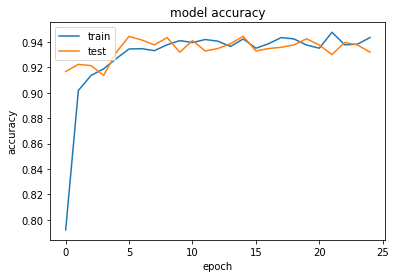

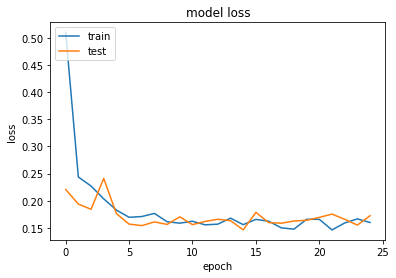

In [8]:
# list all data in history
print(history.history.keys())

import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()